In [2]:
import os
import regex as re
from sklearn.model_selection import train_test_split
def extract_full_sentences(file_path,test_size = None,shuffle = None, pos = False):
    username = r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)'
    random_state = 42
    X = []
    y = []
    temp_X = []
    temp_y = []
    with open(file_path, 'r', encoding="utf8") as fin :
        for l in fin :
            l = l.rstrip().split("\t")
            if l != [""]:
                if pos :
                    temp_X.append(f"{re.sub(username, 'USR', l[1].lower())}_{l[3]}")
                else :
                    temp_X.append(f"{re.sub(username, 'USR', l[1].lower())}")
                temp_y.append(l[7])
            else :
                X.append(temp_X)
                temp_X = []
                y.append(temp_y)
                temp_y = []

    X.append(temp_X)
    y.append(temp_y)
    if test_size is not None:
        X, X_val, y, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
        return X, X_val, y, y_val

    else :
        return X,y

In [3]:
def write_data(X_test, y_test, filename):
	#xi_test format: num, word, lem, POS
	with open(filename, 'w', encoding='utf-8') as f:
		is_first = True
		for xi_test, yi_test in zip(X_test, y_test):
			if (not is_first) and xi_test[0] == 1:
				f.write('\n')
			f.write(f'{xi_test[0]}\t{xi_test[1]}\t-\t{xi_test[3]}\tO\t0\t\t{yi_test}\n')
			is_first = False
		f.write('\n')

In [4]:
import torch

class SstDataset(torch.utils.data.Dataset):
    def __init__(self, encodings,labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

https://github.com/soutsios/pos-tagger-bert/blob/master/pos_tagger_bert.ipynb

POS = True pour intégrer les POS dans l'entrainement et l'inférence du modèle

In [5]:
POS = True

In [6]:
X_train, X_val, y_train, y_val = extract_full_sentences('../dimsum-data-1.5/dimsum16.train',0.15,True,pos=POS)
print(X_train[0])
print(y_train[0])

['the_DET', 'night_NOUN', 'that_PRON', 'jam_PROPN', 'master_PROPN', "jay's_PROPN", 'hand_NOUN', 'slipped_VERB', '!_PUNCT', 'analysis_NOUN', 'by_ADP', 'cosmo_PROPN', 'baker_PROPN', ':_PUNCT', 'url_X']
['', 'n.time', '', 'n.body', '', '', '', 'v.motion', '', 'n.act', '', 'n.person', '', '', '']


In [7]:
tags = set([item for sublist in y_train for item in sublist])
print('TOTAL TAGS: ', len(tags))

TOTAL TAGS:  42


In [8]:
tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i
    int2tag[i] = tag

In [9]:
def map_tagging(y):
    temp_y = []
    for sentence in y :
        temp_y.append([tag2int[tag] for tag in sentence])
    return temp_y

In [10]:
y_train = map_tagging(y_train)
y_val = map_tagging(y_val)

In [11]:
MAX_SEQUENCE_LENGTH = 70
EPOCHS = 30

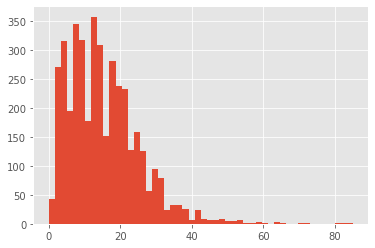

In [12]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [14]:
def tokenize_and_align_labels(X,y):
    tokenized_inputs = tokenizer(X, padding=True, truncation=True, max_length = 35, is_split_into_words=True)

    labels = []
    for i, label in enumerate(y):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])

        labels.append(label_ids)

    return tokenized_inputs, labels

In [15]:
tokenized_train, padded_label_train = tokenize_and_align_labels(X_train,y_train)
tokenized_val, padded_label_val = tokenize_and_align_labels(X_val,y_val)

In [16]:
print(tokenized_train[0])
print(padded_label_train[0])

Encoding(num_tokens=35, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
[-100, 0, 0, 0, 26, 26, 26, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 36, 36, 0, 0, 0, -100]


In [17]:
train_dataset = SstDataset(tokenized_train,padded_label_train)
val_dataset = SstDataset(tokenized_val,padded_label_val)

In [18]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [19]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(tags))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

In [20]:
training_args = TrainingArguments(
    output_dir="./results_12epochs_batch64_pos",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=12,
    weight_decay=0.01,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [22]:
trainer.train()

***** Running training *****
  Num examples = 4085
  Num Epochs = 12
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 768
C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\data\data_collator.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_length = torch.tensor(batch["input_ids"]).shape[1]
C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\data\data_collator.py:328: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 721
  Batch size = 64
***** Running Evaluation *****
  Num examples = 721
  Batch size = 64
***** Running Evaluation *****
  Num examples = 721
  Batch size = 64
***** Running Evaluation *****
  Num examples = 721
  Batch size = 64
***** Running Evaluation *****
  Num examples = 721
  Batch size = 64
***** Running Evaluation *****
  Num examples = 721
  Batch size = 64
***** Running Evaluation *****
  Num examples = 721
  Batch size = 64
Saving model checkpoint to ./results_12epochs_batch64_pos\checkpoint-500
Configuration saved in ./results_12epochs_batch64_pos\checkpoint-500\config.json
Model weights saved in ./results_12epochs_batch64_pos\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results_12epochs_batch64_pos\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results_12epochs_batch64_pos\checkpoint-500\special_tokens_map.json
C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\

TrainOutput(global_step=768, training_loss=0.5181901355584463, metrics={'train_runtime': 246.0998, 'train_samples_per_second': 199.187, 'train_steps_per_second': 3.121, 'total_flos': 438132125617200.0, 'train_loss': 0.5181901355584463, 'epoch': 12.0})

Default batch_size was 16 for both eval and train

For 12 epochs :
    TrainOutput(global_step=3072, training_loss=0.3117038222650687, metrics={'train_runtime': 647.8535, 'train_samples_per_second': 75.665, 'train_steps_per_second': 4.742, 'total_flos': 1139143526604720.0, 'train_loss': 0.3117038222650687, 'epoch': 12.0})

for 12 epochs with batch_size=64 :
    TrainOutput(global_step=768, training_loss=0.5313298602898916, metrics={'train_runtime': 554.7323, 'train_samples_per_second': 88.367, 'train_steps_per_second': 1.384, 'total_flos': 1139143526604720.0, 'train_loss': 0.5313298602898916, 'epoch': 12.0})

for 12 epochs with batch_size=64 and POS :
    TrainOutput(global_step=768, training_loss=0.5026372075080872, metrics={'train_runtime': 243.8739, 'train_samples_per_second': 201.006, 'train_steps_per_second': 3.149, 'total_flos': 438132125617200.0, 'train_loss': 0.5026372075080872, 'epoch': 12.0})

In [23]:
from transformers import pipeline

nerpipeline = pipeline('ner', model=model, tokenizer=tokenizer, device = 0, aggregation_strategy ='simple')
text = "usr i hear enough talking, just turn round keep walking ahaha"
pred = nerpipeline(text)

In [24]:
print(pred)

[{'entity_group': 'LABEL_0', 'score': 0.7907538, 'word': 'usr i hear enough talking, just turn round keep walking ahaha', 'start': 0, 'end': 61}]


In [25]:
for token in pred :
    word = token['word']
    pred_sst = int2tag[int(token['entity_group'].split("_")[1])]
    print(f"{word}", end ="")
    if pred_sst != "":
        print(f" : {pred_sst}")
    else :
        print()

usr i hear enough talking, just turn round keep walking ahaha


In [26]:
def decode_pred(X_test,pred):
    y = []
    i = 0
    for token in pred :
        # print(X_test[i])
        # print(token)
        pred_sst = int2tag[int(token['entity_group'].split("_")[1])]

        while i < len(X_test) and X_test[i].lower() in token['word'] :
            y.append(pred_sst)
            i+=1

    return y

In [27]:
X_test, y_test = extract_full_sentences('../dimsum-data-1.5/dimsum16.test',pos=POS)
if POS :
    X_allign, _ = extract_full_sentences('../dimsum-data-1.5/dimsum16.test')
else :
    X_allign = X_test

y_pred = []
for sentence,sentence_wo_pos in zip(X_test,X_allign) :
    # print(sentence)
    pred = decode_pred(sentence_wo_pos,nerpipeline(' '.join(sentence)))
    # print(' '.join(sentence))
    y_pred.append(pred)
    # print(pred)

C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\pipelines\base.py:1077: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [28]:
print(X_test[0])
print(tokenizer(X_test[0]))
print(y_pred[0])

['USR_X', 'i_PRON', 'hear_VERB', 'enough_ADV', 'talking_VERB', ',_PUNCT', 'just_ADV', 'turn_VERB', 'round_ADV', 'keep_VERB', 'walking_VERB', 'haha_INTJ', 'in_ADP', 'that_DET', 'part_NOUN']
{'input_ids': [[101, 2149, 2099, 1035, 1060, 102], [101, 1045, 1035, 4013, 2078, 102], [101, 2963, 1035, 12034, 102], [101, 2438, 1035, 4748, 2615, 102], [101, 3331, 1035, 12034, 102], [101, 1010, 1035, 26136, 6593, 102], [101, 2074, 1035, 4748, 2615, 102], [101, 2735, 1035, 12034, 102], [101, 2461, 1035, 4748, 2615, 102], [101, 2562, 1035, 12034, 102], [101, 3788, 1035, 12034, 102], [101, 5292, 3270, 1035, 20014, 3501, 102], [101, 1999, 1035, 4748, 2361, 102], [101, 2008, 1035, 20010, 102], [101, 2112, 1035, 15156, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]

In [29]:
for sentence, pred, gold in zip(X_test,y_pred,y_test):
    for word, pred_tag, gold_tag in zip(sentence, pred, gold):
        print(f"{word}", end ="")
        if pred_tag != "" or gold_tag != "" :
            print(f" | pred :{pred_tag}| gold :{gold_tag} ")
        else :
            print()
    break

USR_X
i_PRON
hear_VERB |pred :v.communication|gold :v.perception 
enough_ADV
talking_VERB |pred :v.communication|gold :v.communication 
,_PUNCT
just_ADV
turn_VERB |pred :v.motion|gold :v.motion 
round_ADV
keep_VERB |pred :v.stative|gold :v.stative 
walking_VERB |pred :v.motion|gold :v.motion 
haha_INTJ
in_ADP
that_DET
part_NOUN |pred :n.quantity|gold :n.location 


In [30]:
print(X_test[133])

['fuck_VERB', '\ue139_PRON']


Un cas un peu bizarre à cause d'un caractére spécial

In [31]:
nerpipeline(' '.join(X_test[133]))

[{'entity_group': 'LABEL_0',
  'score': 0.59910697,
  'word': 'fuck _ verb _ pron',
  'start': 0,
  'end': 16}]

In [32]:
print(y_pred[133])

['']


In [33]:
print(len(X_test))
print(len(y_pred))

1000
1000


In [34]:
def write_pred(gold_file,y_pred,post  = ""):
    i = 0
    j = 0
    with open(gold_file, 'r', encoding='utf-8') as f_gold :
        with open(f"{'.'.join(gold_file.split('.')[:-1])}.{post}.pred", 'w', encoding='utf-8') as f_pred :
            for line in f_gold:
                line = line.rstrip().split("\t")
                if line != [""] :
                    # print(f"i : {i}")
                    # print(f"j : {j}")
                    # print(y_pred[i])
                    if j >= len(y_pred[i]): #Pour les cas ??????????????
                        pred = ""
                    else :
                        pred = y_pred[i][j]

                    line[7] = pred
                    line[4] = "O" #Car on n'a pas prédit les MWEs
                    line[5] = "0" #Car on n'a pas prédit les MWEs
                    j+=1
                if line == [""] :
                    i+=1
                    j=0
                f_pred.write('\t'.join(line))
                f_pred.write('\n')

In [35]:
write_pred("../dimsum-data-1.5/dimsum16.test",y_pred,"12epochs_batch_size64_pos")